# Deep Learning with Python

# 5.4 - Visualizing what Convnets Learn

## 5.41 - Visualizing Intermediate Activations

In [1]:
# First, import the cats and dog models trained with data augmentation

In [3]:
from tensorflow.keras.models import load_model

In [ ]:
model = load_model('cats_and_dogs_small_2.h5')

In [ ]:
# As a reminder, here is the summary of the models
model.summary()

### Getting a Single Image for Testing

In [8]:
img_path = '/Users/saads/OneDrive/Desktop/DL-Python/chapter-5/cats_and_dogs_small/test/cats/cat.1700.jpg'

In [9]:
# Module for manipulating Images as objects programmatically
from tensorflow.keras.preprocessing import image

In [10]:
# Images will be encoded as `numpy` tensors
import numpy as np

In [11]:
# Use the img path to load the image into the workspace
img = image.load_img(img_path, target_size=(150, 150))

In [12]:
# Convert the image to a numpy array of width, height, and RGB depth
img_tensor = image.img_to_array(img)

In [13]:
# expanding the rows of the tensor? Why?
img_tensor = np.expand_dims(img_tensor, axis=0)

In [14]:
# Scaling the pixels by .255 because the model was trained on inputs
# that were preprocessed this way
img_tensor /= 255

In [15]:
# Checking that the image tensor has the right shape
img_tensor.shape

(1, 150, 150, 3)

### Displaying the Test Image

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

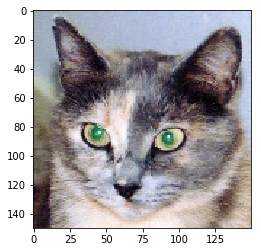

In [19]:
# Image tensor has only one sample along the batch axis - the test image
plt.imshow(img_tensor[0]) # pass this to the imshow command 
plt.show()                # render the plot

### Extracting Feature Maps
In order to extract feature maps, we will create a Keras model that takes batches of images as input and outputs the activations of all convolution and pooling layers.

This will require the use of the Keras class `Model`, which is instantiated using an input tensor (or list of tensors) and an output tensor (or list of tensors).

The resulting object has a class of Model, just as `Sequential` does and maps specified inputs to specified outputs. The difference is that the `Model` class allows for models that have multiple outputs. 

In [21]:
from tensorflow.keras import models

In [23]:
# Making a list of of layer activations for the original model's convnet base
layer_outputs = [layer.output for layer in model.layers[:8]]

# Creates a model that will return the specified outputs, given the inputs
activation_model = models.Model(inputs=model.input, outputs=layers.outputs)

NameError: name 'model' is not defined

In [ ]:
# Passing the image tensor as an input to the model 
# The model will then produce 8 outputs - each is the activation map 
# of each convolutional layer in the model for that input
activations = activation_model.predict(img_tensor)

In [ ]:
# As an example, the activation of the first convolutional layer is
first_layer_activation = activations[0]
print(first_layer_activation.shape)

`(148, 148, 32)` feature map i.e. a feature map which shows the response of 32 different filters to an input image in the form of a 148 x 148 pixel image.

### Visualizing the Fourth Channel

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
# Show the activation map of the 4th filter in the first layer
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

NameError: name 'first_layer_activation' is not defined

In [ ]:
# Show the activation of the 7th filter/channel
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

### Visualizing Every Channel in Every Intermediate Activation

Each convolutional layer in the model will have its own set of (relatively) indpendent filters. The number of filters increases the deeper we go into the network.

So to visualize all the activations of all the filters in all the layers in one diagram, we will be using the following program.

In [ ]:
# Empty list to store the names of all layers - will add to plot labels
layer_names = []

# Parse the first 8 layers i.e. the convolutional layers in the model; 
for layer in model.layers[:8]:
    layer_names.append(layer.name) # add this layers name to the list of name

# In each row of the diagram, we will have 16 activation maps
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    # Number of feature maps for this layer - stored as last arg of numpy array
    n_features = layer_activation.shape[-1]
    
    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]             # width or height
    
    # Tiles the activation channels in this matrix
    n_cols = n_features // images_per_row
    
    # Tiles each filter into a big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, 
                                            col * images_per_row * size]
        
        # Processing each image to make it more visually palatable
        channel_image -= channel_image.mean()    # regularize by mean
        channel_image /= channel_image.std()     # regularize by standard deviation
        channel_image *= 64                      # scale all pixels by 64 - why?
        channl_image += 128                      # bias of 128 to each pixel - why?
        channel_image = np.clip(channel_image, 0, 255).astype('unit8')
        display_grid[col * size : (col + 1) * size, 
                    row * size : (row + 1) * size] = channel_image
    
    scale = 1./size
    plt.figure(figsize=(scale * display_grid.shape[1], 
                       scale * display_grid.shape[0]))
    
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmpa='viridis')

## 5.42 - Visualizing Convnet Filters

In the previous section, we fed an image as an input to a layer in the convnet and inferred the meaning of filters by observing the extent to which regions of the picture led to the maximum activation in the filters.

We will now take this a step further and take a more generic approach to the problem: given the filter for a convnet layer, we will find the input image that will maximise its output by starting from a gray, random array of pixels that will eventually be optimised to find the optimal image that leads to maximum activation of the specific filter.

Concretely, we will develop a cost function or loss function that maximises the value of a given filter for a given convolutional layer, and then use gradient descent to adjust the values of the input image so as to maximize this activation value.

In [26]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K

In [ ]:
# Instantiate the VGG16 model to access a conv layer
model = VGG16(weights='imagenet', include_top=False)

In [ ]:
# Defining the name of the layer we will extract from the model
layer_name = 'block3_conv1' # first conv layer of the third block of conv/pool layers

In [ ]:
# The specific filter in the convolutional layer that we will want to extract
filter_index = 0

In [ ]:
# Extract the output of this layer
layer_output = model.get_layer(layer_name).output

In [ ]:
# Loss function for this layer's output is the mean value of all pixels 
# in the activation map for the specific filter we have chosen
loss = K.mean(layer_output[:, :, :, filter_index])

In [ ]:
# Implementing gradient ascent - gradient descent to **maximise** the loss function
# compute gradient of the loss with respect to the model's input
# Gradient represents the variation in the input that causes the largest change in 
# in the value of the loss -> we will move in this direction 

# call to `gradients` returns a list of tensors (of size 1 in this case)
# Hence we keep only the first element - this is a tensor
grads = K.gradients(loss, model.input)[0] 

In [ ]:
# Gradient Normalization Trick
# Divide the gradient by its L2 norm to minimize magnitue of the updates done to the input image
# This ensures that the input image is always within the same range
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)    # add 1e-5 before dividing to avoid div by 0

Now we need to compute the value of the loss tensor and the gradient tensor for a given input image. This is done through the `iterate` function. It takes a `numpy` tensor (as a list of tensors of size 1) and returns a list of two `numpy` tensors - loss value and the gradient value.

In [ ]:
# Iterate is defined as a keras backend function that accepts the 
# model's input as an input and computes the loss and grads that we have defined
iterate = K.function([model.input], [loss, grads])

In [ ]:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

### Stochastic Gradient Descent

In [ ]:
# start from a gray image with some noise
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128

step = 1     # magnitude of each gradient update

# Run stochastic gradient descent for 40 iterations
for i in range(40):
    # Compute the loss and the gradient with a call to the custom iterate function
    loss_value, grads_value = iterate([input_img_data])
    
    # The update defines how to modify individual pixels in the input_img
    # according to the gradient and the step size
    input_img_data += grads_value * step

### Image Postprocessing
The tensor returned by stochastic gradient descent is a tensor of shape (1, 150, 150, 3) with values that may or may not be within $[0, 255]$. Hence, the image needs to be postprocessed to turn it into a displayable image.

In [27]:
def deprocess_image(x):
    x -= x.mean()               # regularize through mean - centered on 0
    x /= (x.std() + 1e-5)       # regularize through standard deviation
    x *= 0.1                    # ensure that new std dev is 0.1
    
    # Clip the image to [0, 1]
    x += 0.5                    # increase each pixels value by 0.5
    x = np.clip(x, 0, 1)        # remove any pixels that fall outside the [0, 1] range
    
    # Conver to an RGB array
    x *= 255 
    x = np.clip(x, 0, 255).astype('unit8')
    return x

### Single Python Function for Generating Filter Pattern

In [ ]:
def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation of the `nth` filter of the layer under construction
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output, [:, :, :, filter_index])
    
    # Computes the gradient of the input picture with regard to this loss
    grads = K.gradients(loss, model.input)[0]
    
    # Normalization trick: normalizes the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    # Returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # Start frm a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128. # float 128!
    
    # Run gradient descent for 40 steps
    step = 1
    for i in range(40):
        # Use `iterate` to get the gradient and loss for the current step
        loss_value, grads_value = iterate([input_img_data])
        
        # Increase the value of all pixels by the amount that will maximise the activation
        input_img_data += grads_value * step
        
    # The iterate function will return an array with only one value
    img = input_img_data[0]
    
    
    # Regularize mean to 0, shift std dev to 0.1, clip px outside [0, 1], convert to RGB array
    return deprocess_image(img)

### Visualizing a Single Filter

Visualizing the 0th fitler of the first convolutional layer of the third block of conv/pool layers in the model.

In [ ]:
plt.imshow(generate_pattern('block3_conv1', 0))

### Visualizing Multiple Filters
- Visualizing activation maps of the first 64 filters in the first convolutional layer of each convolutional block.
- Outputs will be arranged in an $8\times8$ grid of $64\times64$ filter patterns, with some black margins between each filter pattern.

In [31]:
layer_name = 'block_conv1'
size = 64
margin = 5

# Creating an empty numpy array with enough pixels to hold all images and margins
results = np.zeros((8 * size + 7 * margin,    # width in pixels
                     8 * size + 7 * margin,    # height in pixels
                     3))                       # color channels/depth

In [ ]:
# Iterate over the rows of the results grid
for i in range(8):
    for j in range(8):    # iterates over the columns of the results grid
        # Generates the pattern for filter i + (j * 8) in layer_name
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        
        # Puts the ressult in the square (i, j) of the results grid
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size # assume square activation map
        
        results[horizontal_start : horizontal_end, 
               vertical_start : vertical_end, :] = filter_img

# Display the results grid
plt.figure(figsize=(20, 20))
plt.imshow(results)